## Designing target variable

### We aim to compare this type of sales growth measures:

### 1-year growth: The percentage change in sales over a single year (e.g., 2011 to 2012).
### Focusing on the 1-year growth provides a snapshot of a firm’s short-term performance. Businesses operate in dynamic environments, and sales growth over a single year is often an actionable indicator of growth potential.

### The **growth rate** refers to the projected change in sales over the next year, representing the difference in a firm's sales compared to the current year.

### This threshold follows the [OECD](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:High-growth_enterprise)  definition, which indicates a significant year-over-year growth.

In [14]:
# Sort by firm and year
data = data.sort_values(["comp_id", "year"])

# Calculate forward-looking growth rate (future sales vs. this year)
data["growth_rate"] = data.groupby("comp_id")["sales"].shift(-1) / data["sales"] - 1

# Replace inf, -inf with NaN to avoid polluting calculations
data['growth_rate'] = data['growth_rate'].replace([np.inf, -np.inf], np.nan)

In [15]:
# Step 1: Filter out the 99th percentile of growth rates
growth_rate_99th_percentile = data['growth_rate'].quantile(0.99)
data_filtered = data[data['growth_rate'] <= growth_rate_99th_percentile]

# Step 2: Define high-growth firms (growth > 20%)
data_filtered['HG_turnover'] = (data_filtered['growth_rate'] > 0.2).astype(int)

In [16]:
# Step 2.1: Create a shifted HG column to track previous year's status
data_filtered["HG_turnover_prev"] = data_filtered.groupby("comp_id")["HG_turnover"].shift(1)

# Step 2.2: Define transitions
data_filtered["HG_entry"] = np.where(
    (data_filtered["HG_turnover_prev"] == 0) & (data_filtered["HG_turnover"] == 1), 1, 0)

data_filtered["HG_exit"] = np.where(
    (data_filtered["HG_turnover_prev"] == 1) & (data_filtered["HG_turnover"] == 0), 1, 0)

# Step 3: Summarize transitions and growth metrics by year
hg_summary = data_filtered.groupby('year').apply(
    lambda x: pd.Series({
        'num_firms': x['comp_id'].nunique(),
        'hg_firms_share_percentage_next_period': (x['HG_turnover'].sum() / x['comp_id'].nunique()) * 100,
        'avg_growth_rate_hg': x.loc[x['HG_turnover'] == 1, 'growth_rate'].mean(),
        'avg_growth_rate_non_hg': x.loc[x['HG_turnover'] == 0, 'growth_rate'].mean(),
        'hg_entry_count': x['HG_entry'].sum(),
        'hg_exit_count': x['HG_exit'].sum(),
        'hg_entry_share_percentage': (x['HG_entry'].sum() / x['comp_id'].nunique()) * 100,
        'hg_exit_share_percentage': (x['HG_exit'].sum() / x['comp_id'].nunique()) * 100
    })
).reset_index()

# Step 4: Clean up the table
pretty_hg_summary = (
    hg_summary
    .rename(columns={
        'year': 'Year',
        'num_firms': 'Firms',
        'hg_firms_share_percentage_next_period': 'HG Share (%)',
        'avg_growth_rate_hg': 'Avg Growth (HG)',
        'avg_growth_rate_non_hg': 'Avg Growth (Non-HG)',
        'hg_entry_count': 'HG Entries',
        'hg_exit_count': 'HG Exits',
        'hg_entry_share_percentage': 'Entry Share (%)',
        'hg_exit_share_percentage': 'Exit Share (%)'
    })
    .round({
        'HG Share (%)': 2,
        'Avg Growth (HG)': 2,
        'Avg Growth (Non-HG)': 2,
        'Entry Share (%)': 2,
        'Exit Share (%)': 2
    })
)

# Convert count columns to integers
for col in ['Firms', 'HG Entries', 'HG Exits']:
    pretty_hg_summary[col] = pretty_hg_summary[col].astype(int)

# Display nicely
from IPython.display import display
display(pretty_hg_summary)

,Year,Firms,HG Share (%),Avg Growth (HG),Avg Growth (Non-HG),HG Entries,HG Exits,Entry Share (%),Exit Share (%)
0,2009,18709,28.26,2.23,-0.20,0,0,0.00,0.00
1,2010,19100,32.10,2.05,-0.18,2859,3239,14.97,16.96
2,2011,19640,29.89,2.08,-0.20,2553,4060,13.00,20.67
3,2012,19703,32.08,1.98,-0.18,3158,3708,16.03,18.82
4,2013,19728,36.97,1.78,-0.16,3684,3707,18.67,18.79
5,2014,19711,33.80,1.65,-0.14,3210,4626,16.29,23.47


## Focus on 2012 Transitions
### We selected 2012 as the reference year to ensure a sufficiently large sample while keeping a balanced rate of high-growth firm entries and exits.

### Instead of merely examining the proportion of high-growth firms, we analyze transitions—specifically, how many firms enter or exit the high-growth category. This approach provides insight into the dynamics and mobility of firm performance over time.

## Feature engineering

### Same as in ch17-firm-exit-data-prep.ipynb

In [60]:
# generate variables [profit/loss] ---------------------------------------------------
data["profit_loss_year_mil"] = data["profit_loss_year"] / 1_000_000

In [61]:
# Then apply signed log transform
data["profit_loss_year_mil_log"] = (
    np.sign(data["profit_loss_year_mil"]) * np.log1p(np.abs(data["profit_loss_year_mil"]))
)

### Profit / Loss Year → Transformed as Log

### Past profitability indicates a firm's financial health and its capacity for internal funding.

### Extreme profits or losses may highlight risks, investment strategies, or volatility.

### The log-transformed version retains these nuances while preventing excessively large numbers from dominating the model.

## Model building

### Define variable sets as in ch17-predicting-firm-exit.ipynb

 ### Main firm variables, Further financial variables,  Flag variables, Growth variables, Human capital related variables,  Firms history related variables, Interactions for logit, LASSO

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

In [111]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,16,0.452987,0.618541
M2,23,0.447289,0.651345
M3,40,0.442029,0.672425
M4,83,0.439566,0.676471
M5,197,0.440077,0.676408
LASSO,101,0.439519,0.677835


## Best model and estimate RMSE on holdout  

### Both **M4** and **LASSO** perform similarly in terms of predictive accuracy. However, M4 stands out because it uses fewer coefficients than LASSO or M5, which enhances its interpretability. In comparison to simpler models like M1 or M2, M4 delivers notably better predictive performance, especially in terms of AUC, demonstrating superior discrimination ability.

## Conclusion:

### **M4** is chosen as the final model because it provides high predictive accuracy while maintaining a manageable number of features, making it both practical and interpretable for identifying high-growth firms.

In [112]:
best_logit = logit_models["M4"]
model_equation = "HG_turnover~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

### Best logit holdout RMSE


In [113]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["HG_turnover"]), 3)

0.438

In [118]:
thresholds = [0.5, 0.4, 0.35, 0.3]
for t in thresholds:
    preds = np.where(data_holdout["best_logit_pred_proba"] >= t, 1, 0)
    cm = confusion_matrix(data_holdout["HG_turnover"], preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n--- Threshold: {t} ---")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision (HG): {precision_score(data_holdout['HG_turnover'], preds):.3f}")
    print(f"Recall (HG):    {recall_score(data_holdout['HG_turnover'], preds):.3f}")
    print(f"False Negatives (missed HGs): {fn}")
    print(f"False Positives: {fp}")



--- Threshold: 0.5 ---
Confusion Matrix:
[[2297  161]
 [ 859  251]]
Precision (HG): 0.609
Recall (HG):    0.226
False Negatives (missed HGs): 859
False Positives: 161

--- Threshold: 0.4 ---
Confusion Matrix:
[[2071  387]
 [ 692  418]]
Precision (HG): 0.519
Recall (HG):    0.377
False Negatives (missed HGs): 692
False Positives: 387

--- Threshold: 0.35 ---
Confusion Matrix:
[[1878  580]
 [ 583  527]]
Precision (HG): 0.476
Recall (HG):    0.475
False Negatives (missed HGs): 583
False Positives: 580

--- Threshold: 0.3 ---
Confusion Matrix:
[[1613  845]
 [ 429  681]]
Precision (HG): 0.446
Recall (HG):    0.614
False Negatives (missed HGs): 429
False Positives: 845


In [119]:
# Applying different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.4, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["HG_turnover"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm1b

,Predicted non-HG,Predicted HG
Actul non-HG,2071,387
Actual HG,692,418


### A sensible choice: mean of predicted probabilities

In [120]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.316

In [121]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["HG_turnover"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm2

,Predicted non-HG,Predicted HG
Actul non-HG,1720,738
Actual HG,487,623


### c) Visualize ROC (with thresholds in steps) on holdout

### What if we want to compare multiple thresholds?

### First, discrete ROC (with thresholds in steps) on holdout

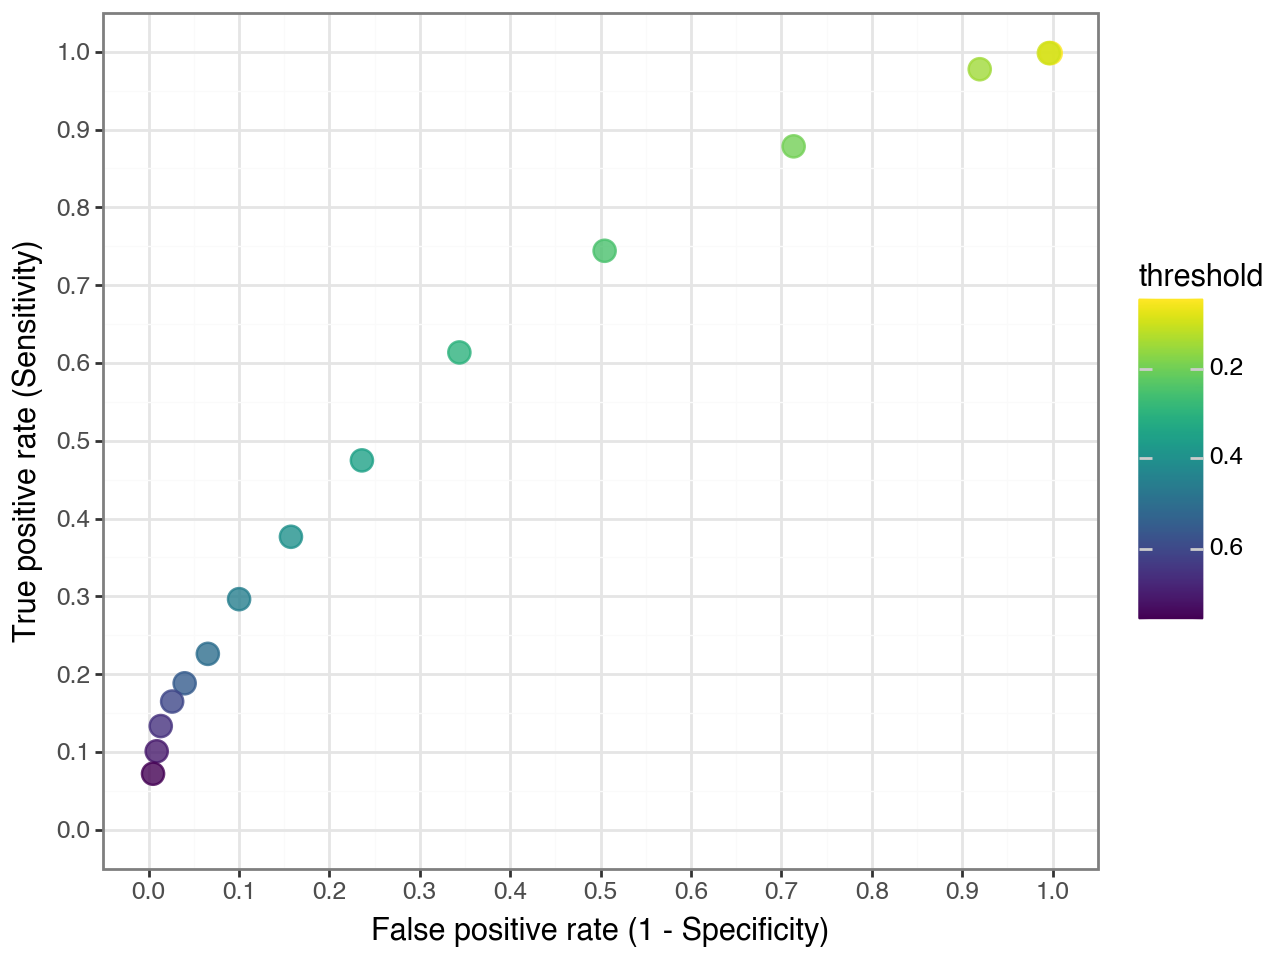

In [124]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

### Continuous ROC on holdout with best model

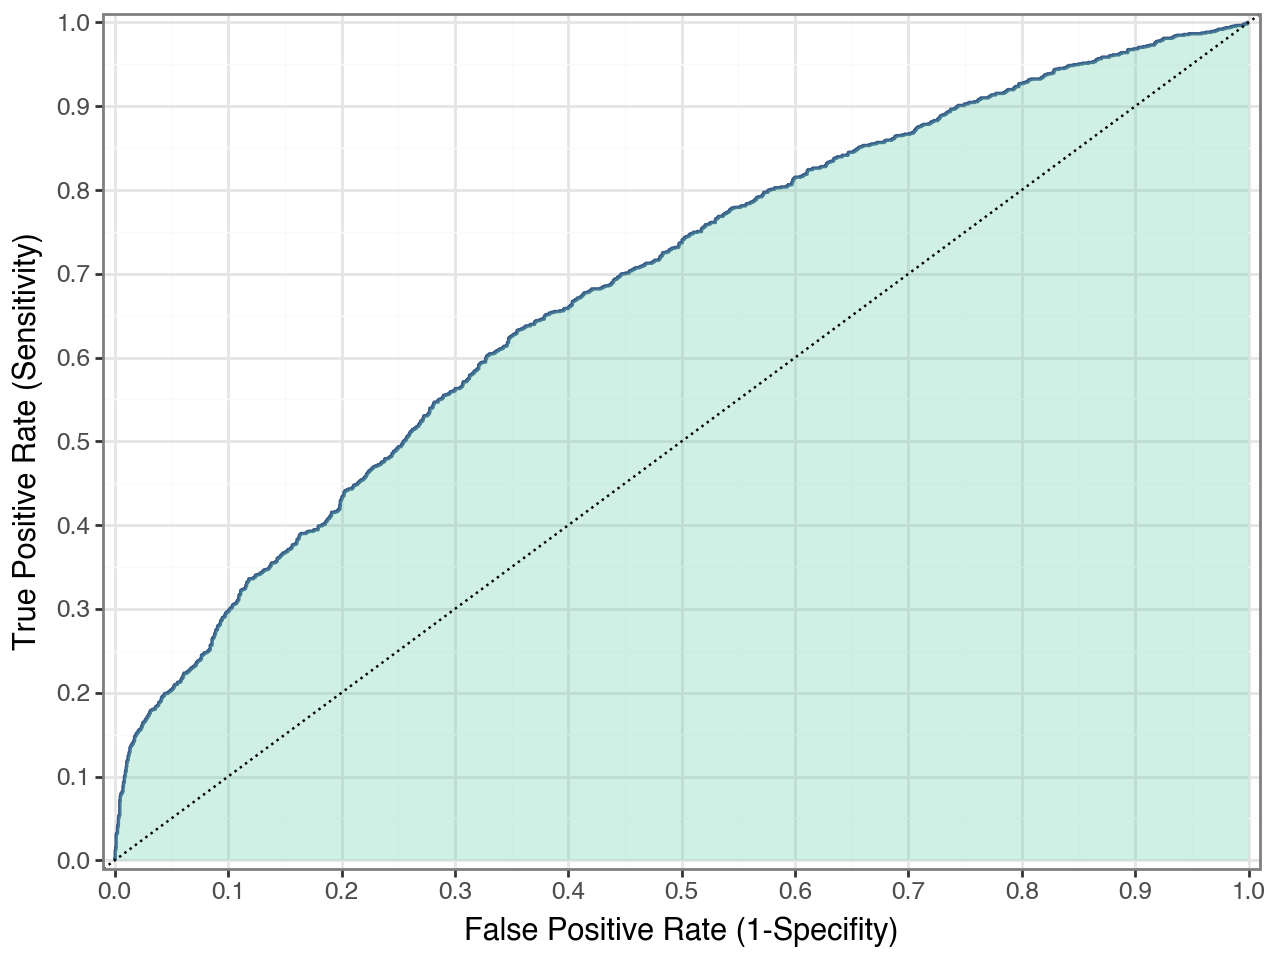

In [125]:
create_roc_plot(data_holdout["HG_turnover"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)

In [126]:
FP = 1
FN = 4
cost = FN / FP

### To align the model evaluation with business goals, we introduced a custom loss function that assigns different costs to classification errors. In our context, a false positive (predicting a firm will grow fast when it won’t) incurs a unit cost of 1, while a false negative (failing to identify a fast-growing firm) has a cost of 4. This cost ratio (FN/FP = 4) reflects the reality that missing a truly high-growth firm—potentially overlooking investment or partnership opportunities—is significantly more costly than mistakenly targeting a slow-growing one.  

### The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [127]:
prevelance = y_train.sum() / len(y_train)

### Draw ROC Curve and find optimal threshold with loss function 

### The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

### Iterate through:
 ### 1. models
 ### 2. Folds

In [130]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.200771,0.201370,0.672017,0.677883
1,M2,0.213057,0.172817,0.663537,0.669120
2,M3,0.194024,0.211113,0.645736,0.651945
3,M4,0.212004,0.198559,0.642862,0.644585
4,M5,0.193520,0.198828,0.640690,0.640379
5,LASSO,0.210698,0.203597,0.640759,0.633368


### Create loss plot based on Fold5 in CV 

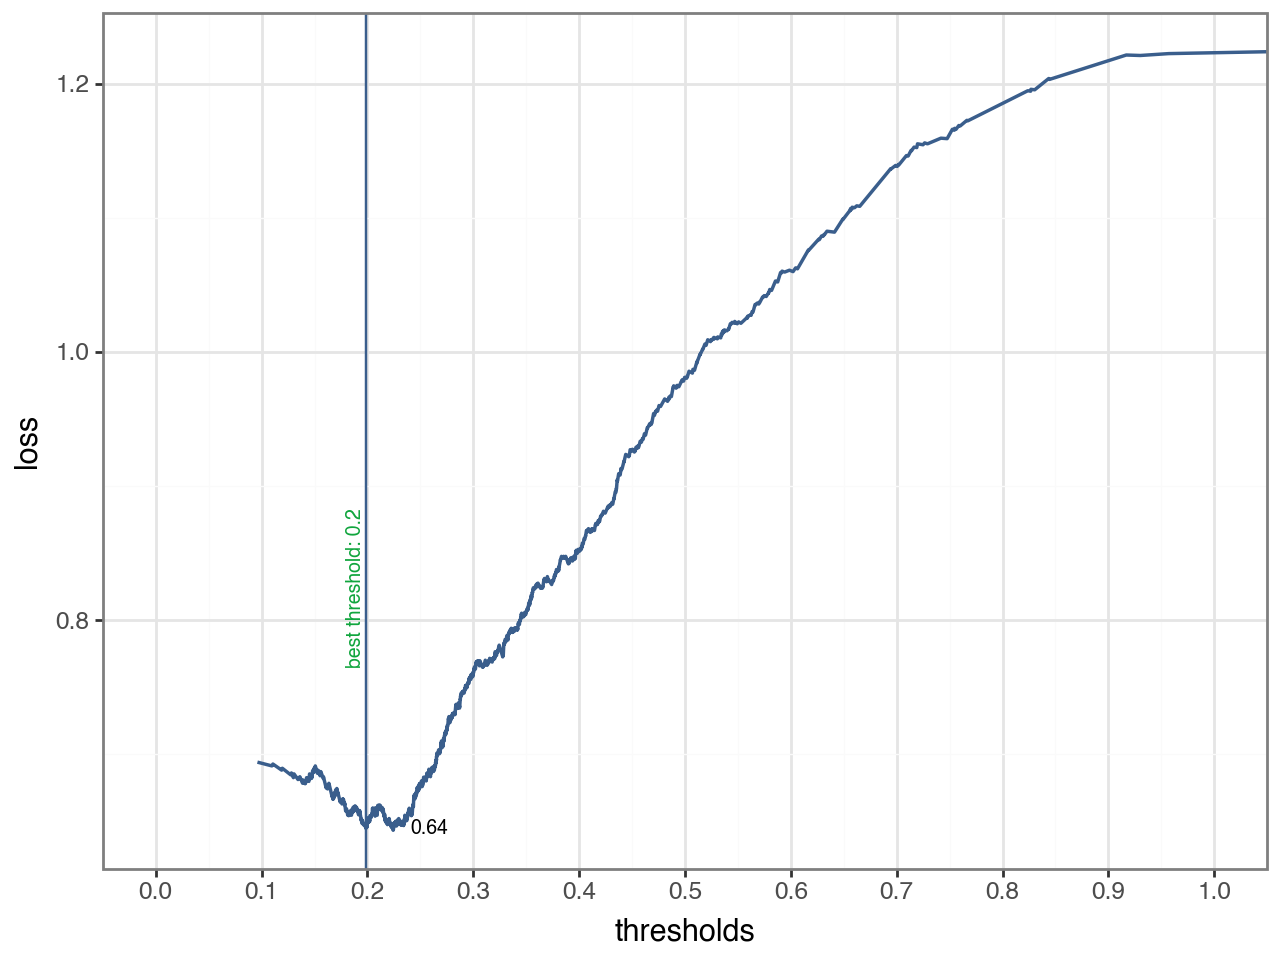

In [131]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

### The optimal threshold (0.2) minimizes the total cost of misclassifications, ensuring the least total loss. At this threshold, we are balancing the costs of both false positives and false negatives effectively, based on the relative importance of these errors.

### Create roc plot plot based on Fold5 in CV

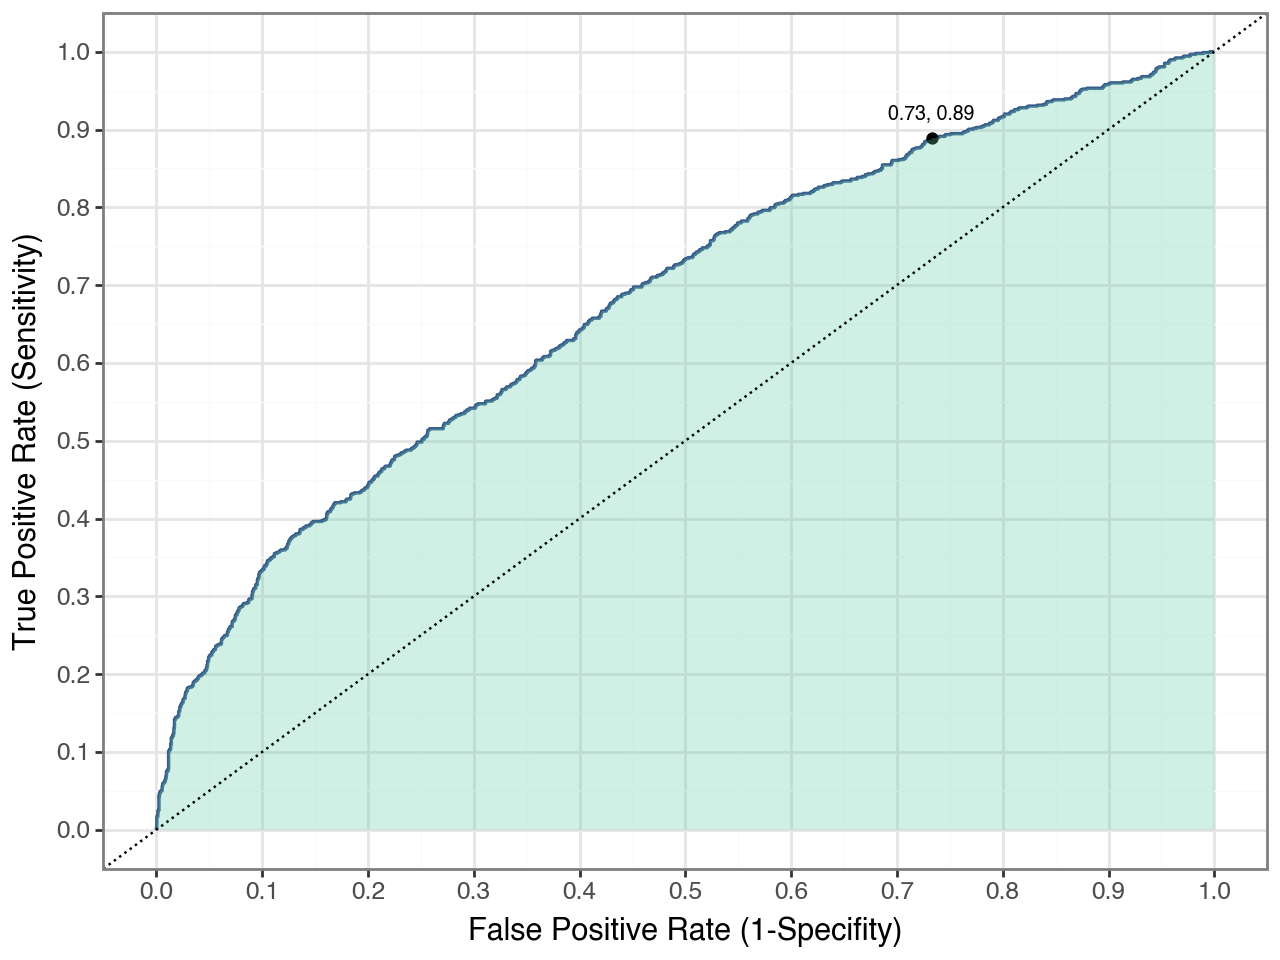

In [132]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

### The coordinates (0.73, 0.89) represent a point where the model is good at identifying high-growth firms (89% of the time) but may also mistakenly label a significant portion of non-high-growth firms as high-growth (73%).

### Let's see our chosen model, M4's holdout expected loss

In [133]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["HG_turnover"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["HG_turnover"])
round(expected_loss_holdout, 3)

0.639

### CM on holdout

In [134]:
cm_object3 = confusion_matrix(data_holdout["HG_turnover"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm3

,Predicted non-HG,Predicted HG
Actual non-HG,839,1619
Actual HG,165,945


## Prediction with Random Forest

## Probability forest

### Split by gini, ratio of 1's in each tree, average over trees

In [142]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,16.0,0.452987,0.618541
M2,23.0,0.447289,0.651345
M3,40.0,0.442029,0.672425
M4,83.0,0.439566,0.676471
M5,197.0,0.440077,0.676408
LASSO,101.0,0.439519,0.677835
RF,n.a.,0.438771,0.676892


In [144]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.453674,0.448324,0.441399,0.439223,0.439766,0.440585,0.439382
1,0.453006,0.447705,0.443118,0.440257,0.440562,0.439641,0.440022
2,0.456544,0.449611,0.447823,0.444704,0.446635,0.445160,0.440743
3,0.451503,0.445823,0.439853,0.437845,0.438358,0.437867,0.438854
4,0.450207,0.444982,0.437950,0.435802,0.435067,0.434342,0.434145


In [145]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.617237,0.647823,0.676916,0.679032,0.675268,0.671822,0.670752
1,0.614185,0.644926,0.665712,0.672574,0.671504,0.675695,0.665764
2,0.619402,0.656878,0.663630,0.666616,0.663469,0.667086,0.679878
3,0.624016,0.659394,0.681763,0.684280,0.687007,0.687960,0.677874
4,0.617864,0.647703,0.674102,0.679852,0.684794,0.686610,0.690193


### Now use loss function and search for best thresholds and expected loss over folds 

In [148]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.439,0.677,0.2,0.219,0.642,0.628


### Create plots based on Fold5 in CV 

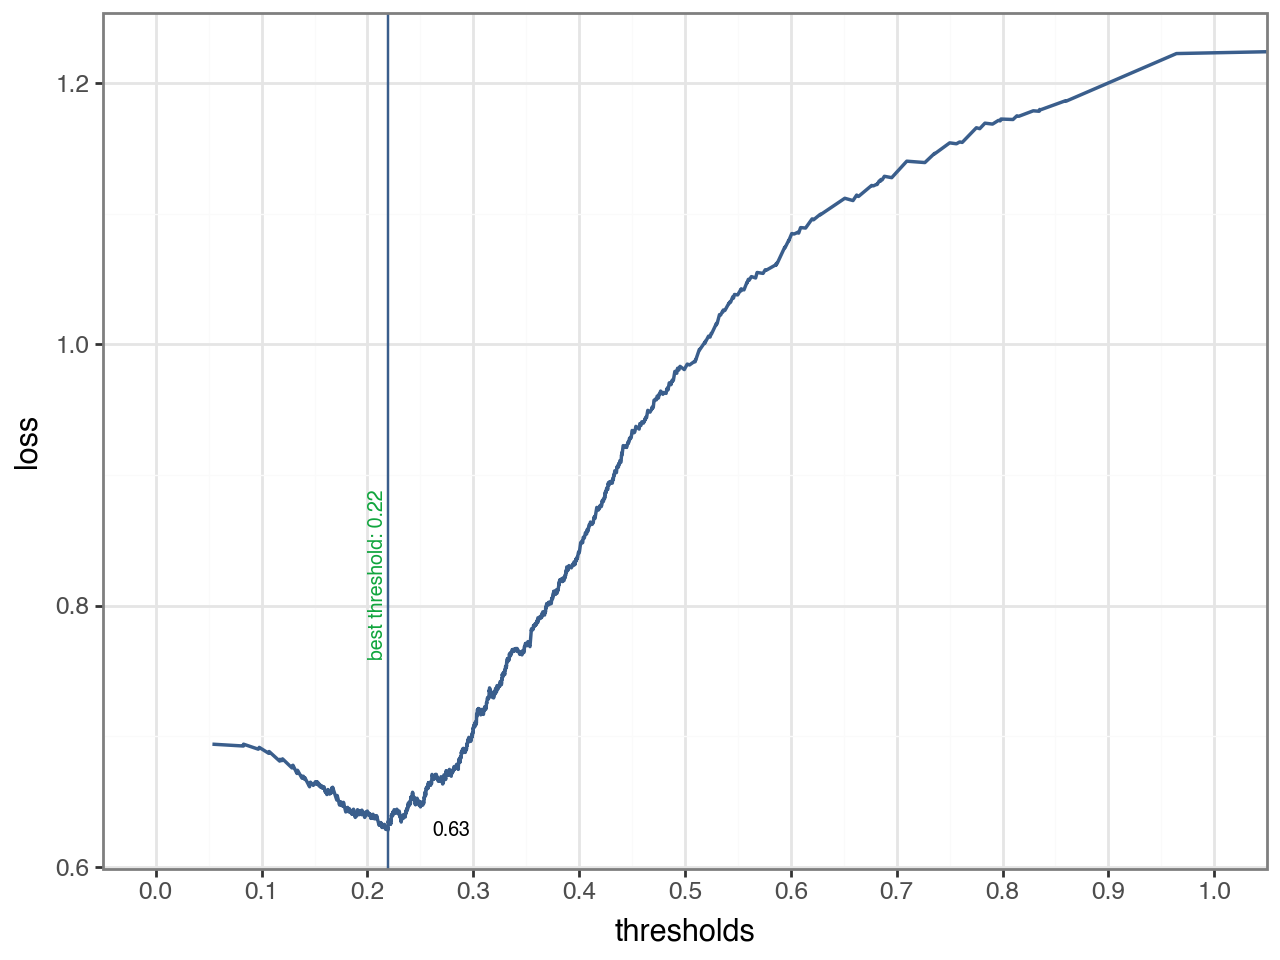

In [149]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

### The optimal threshold (0.22) minimizes the total cost of misclassifications, ensuring the least total loss. At this threshold, we are balancing the costs of both false positives and false negatives effectively, based on the relative importance of these errors.

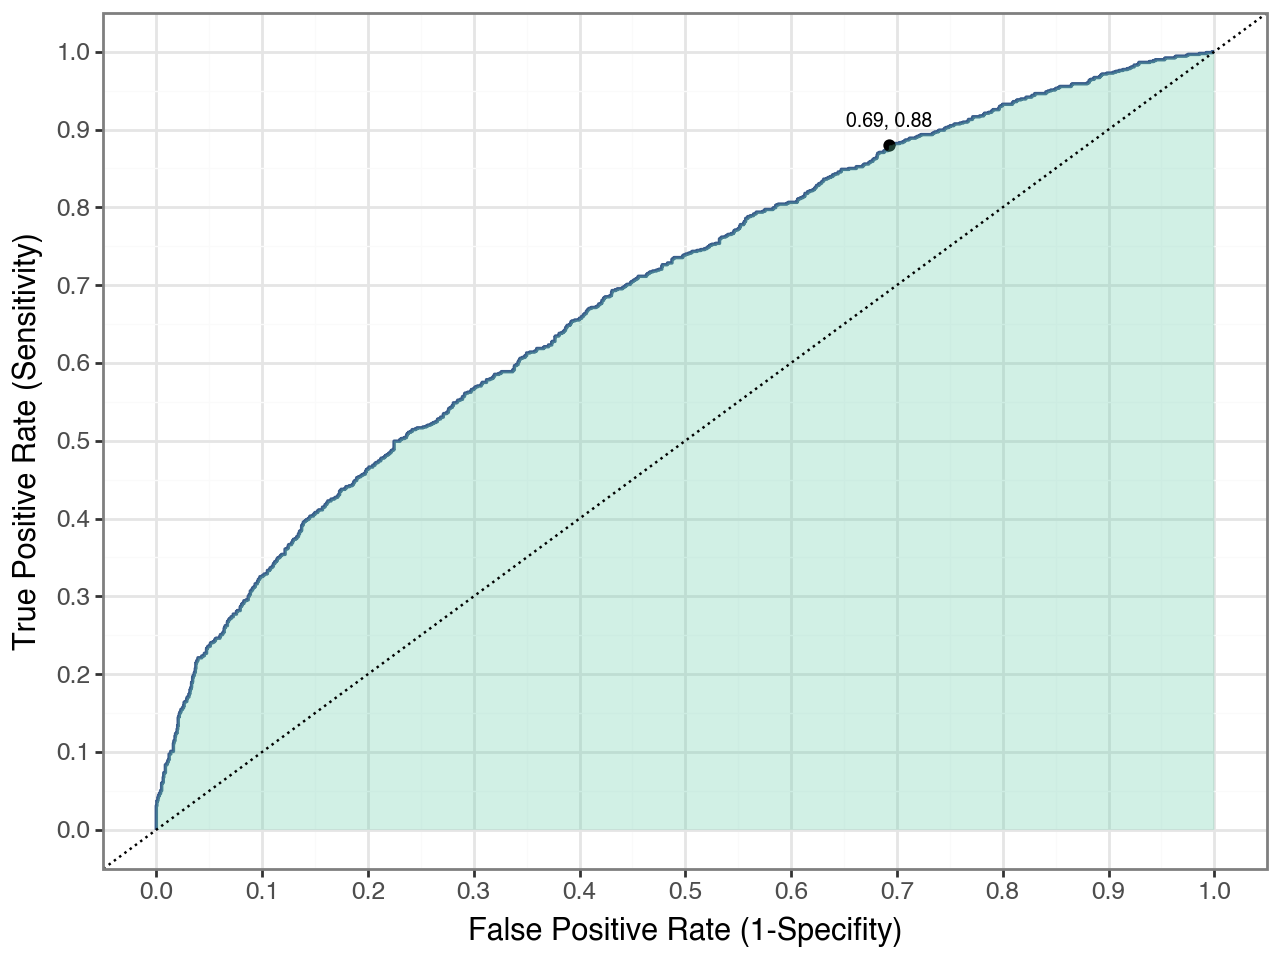

In [150]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

### The coordinates (0.69, 0.88) represent a point where the model is good at identifying high-growth firms (88% of the time) but may also mistakenly label a significant portion of non-high-growth firms as high-growth (69%).

### Take model to holdout and estimate RMSE, AUC and expected loss 

In [151]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.437

## Final results

In [155]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,16.0,0.452987,0.618541,0.200771,0.672017
M2,23.0,0.447289,0.651345,0.213057,0.663537
M3,40.0,0.442029,0.672425,0.194024,0.645736
M4,83.0,0.439566,0.676471,0.212004,0.642862
M5,197.0,0.440077,0.676408,0.193520,0.640690
LASSO,101.0,0.439519,0.677835,0.210698,0.640759
RF,n.a.,0.438771,0.676892,0.199925,0.642090


## Prediction with XGBoost

Plots

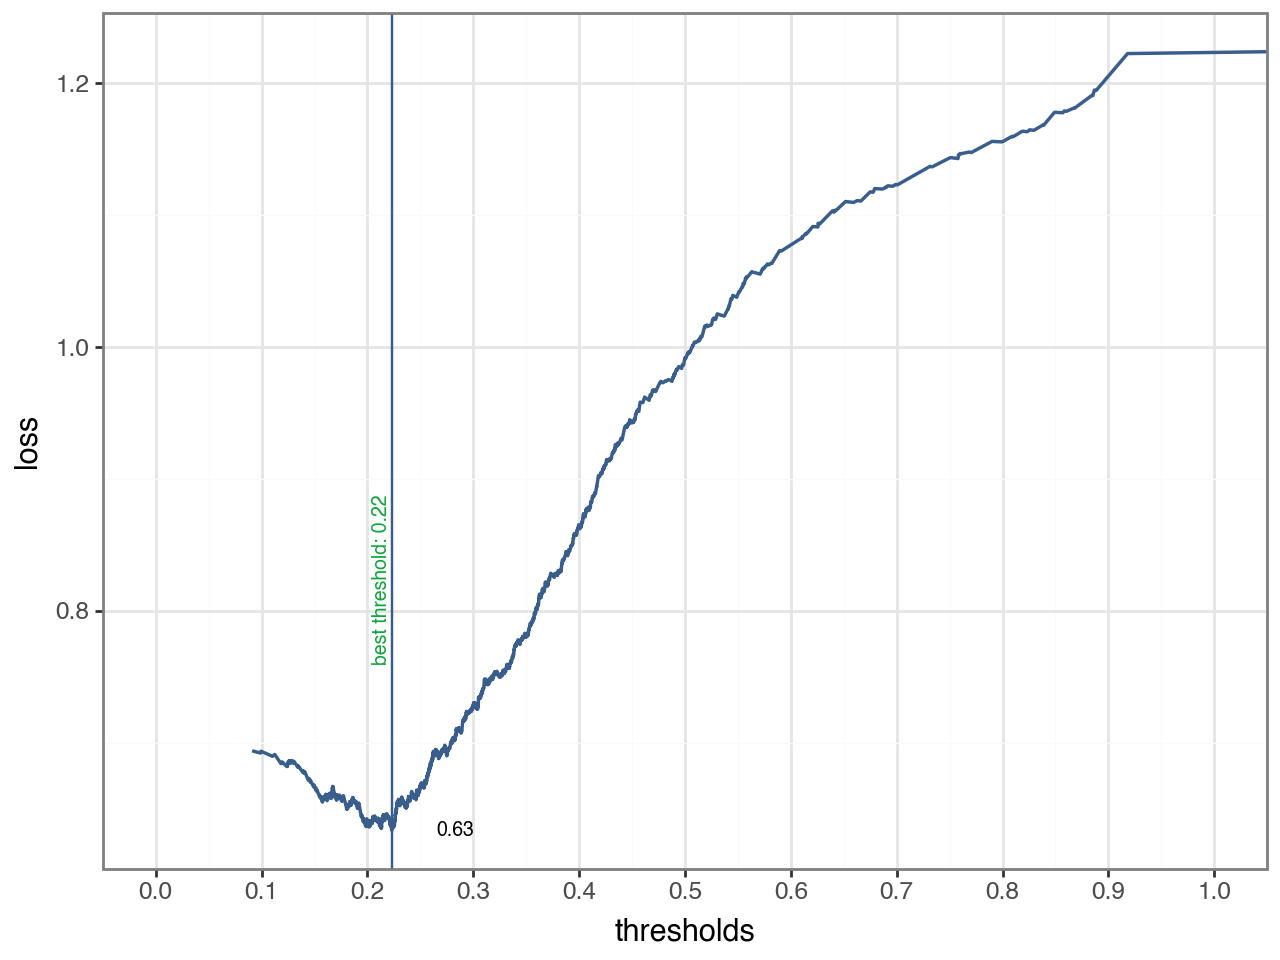

In [163]:
create_loss_plot(all_coords_xgb, fold5_threshold_xgb, fold5_expected_loss_xgb)

### The optimal threshold (0.22) minimizes the total cost of misclassifications, ensuring the least total loss. At this threshold, we are balancing the costs of both false positives and false negatives effectively, based on the relative importance of these errors.

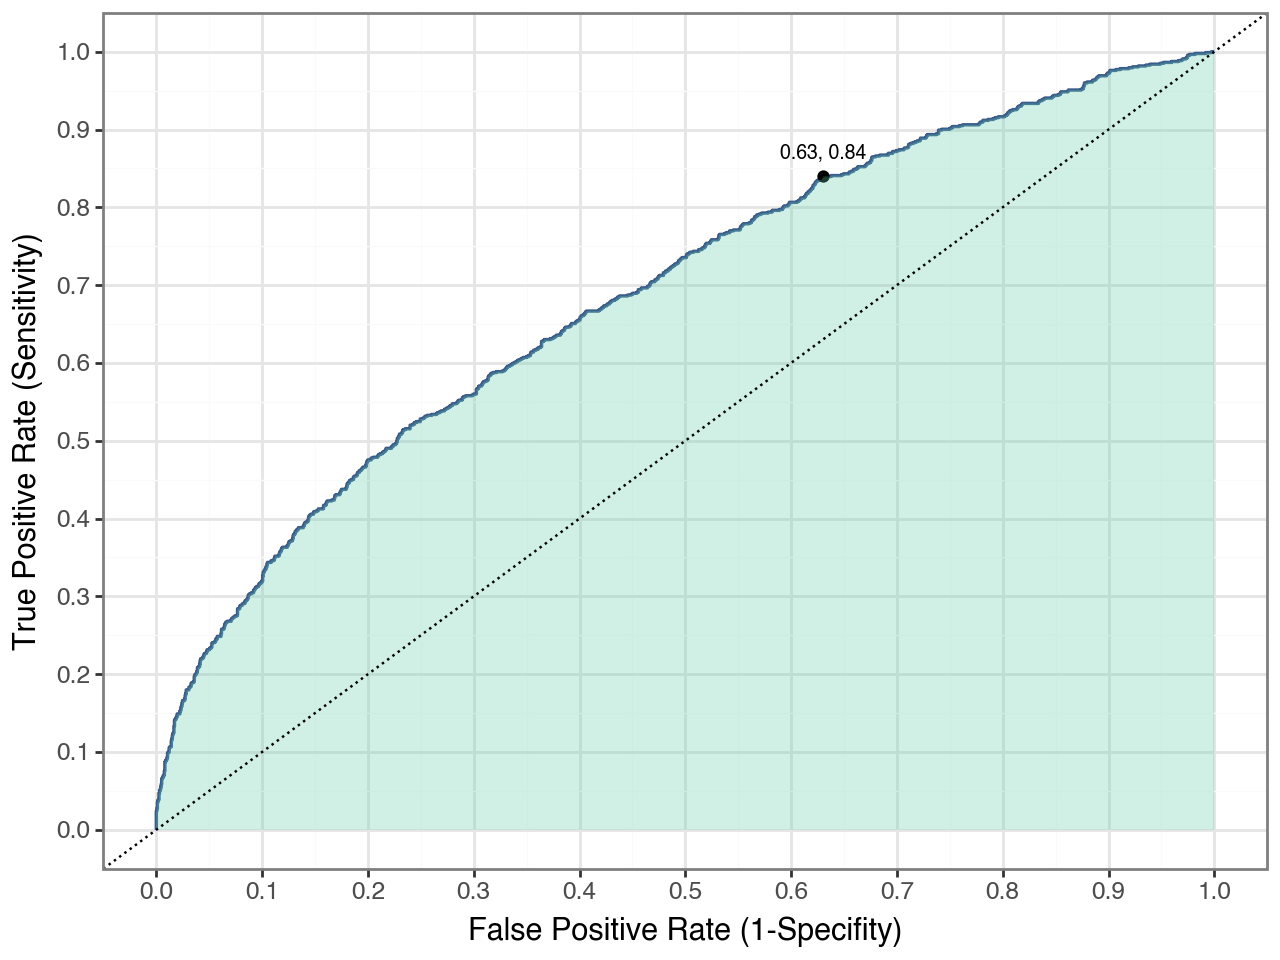

In [164]:
create_roc_plot_with_optimal(all_coords_xgb, fold5_threshold_xgb)

### The coordinates (0.63, 0.84) represent a point where the model is good at identifying high-growth firms (84% of the time) but may also mistakenly label a significant portion of non-high-growth firms as high-growth (63%).

In [167]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,16.0,0.452987,0.618541,0.200771,0.672017
M2,23.0,0.447289,0.651345,0.213057,0.663537
M3,40.0,0.442029,0.672425,0.194024,0.645736
M4,83.0,0.439566,0.676471,0.212004,0.642862
M5,197.0,0.440077,0.676408,0.193520,0.640690
LASSO,101.0,0.439519,0.677835,0.210698,0.640759
RF,n.a.,0.438771,0.676892,0.199925,0.642090
XGB,n.a.,0.437491,0.681730,0.203971,0.639988


## XGBoost has the smallest average (over 5 folds) expected loss, which is 0.639988.

In [169]:
# Predict class labels on holdout set using the CV-optimal threshold
xgb_class_prediction = np.where(y_prob_holdout_xgb < best_thresholds_cv["XGB"], 0, 1)

# Count predicted class distribution
values, counts = np.unique(xgb_class_prediction.tolist(), return_counts=True)
print(values[0], " (non high-growth): ", counts[0])
print(values[1], " (high-growth): ", counts[1])

# Confusion matrix object
cm_object_xgb = confusion_matrix(
    y_holdout, xgb_class_prediction, labels=[0, 1]
)

# Dataframe
cm_xgb = pd.DataFrame(
    cm_object_xgb,
    index=["Actual non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm_xgb

0  (non high-growth):  755
1  (high-growth):  2813


,Predicted non-HG,Predicted HG
Actual non-HG,636,1822
Actual HG,119,991


## Evaluating the model's usefulness:

### The XGBoost model has captured a substantial number of high-growth firms (TP = 991), which could be seen as a success in identifying firms worth focusing on for investment or expansion strategies. However, with the high number of false positives (1,822), the model’s utility may be limited if the business context requires high precision, particularly in a resource-constrained environment where misallocation of resources is costly.

### On the other hand, if the business strategy involves casting a wide net and is less concerned about occasional false positives (perhaps in the context of large-scale investments or marketing), then the model’s performance could still be beneficial. 

# PART 2

In [180]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

In [181]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

In [182]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [183]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [184]:
rfvars = ["sales_mil_log", "sales_mil_log_sq"] + rawvars + hr + firm + qualityvars

In [185]:
y_train, rfvars_train = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_holdout)

## The loss function

### Introduce loss function

### Relative cost of of a false negative classification (as compared with a false positive classification)

In [186]:
FP = 1
FN = 4
cost = FN / FP

### The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))

In [187]:
prevelance = y_train.sum() / len(y_train)

## Prediction with XGBoost

In [188]:
xgb_summary = pd.DataFrame(
    {
        "CV RMSE": [round(xgb_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(xgb_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["XGB"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["XGB"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

xgb_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.438,0.678,0.194,0.205,0.64,0.631


### Create plots based on Fold5 in CV 

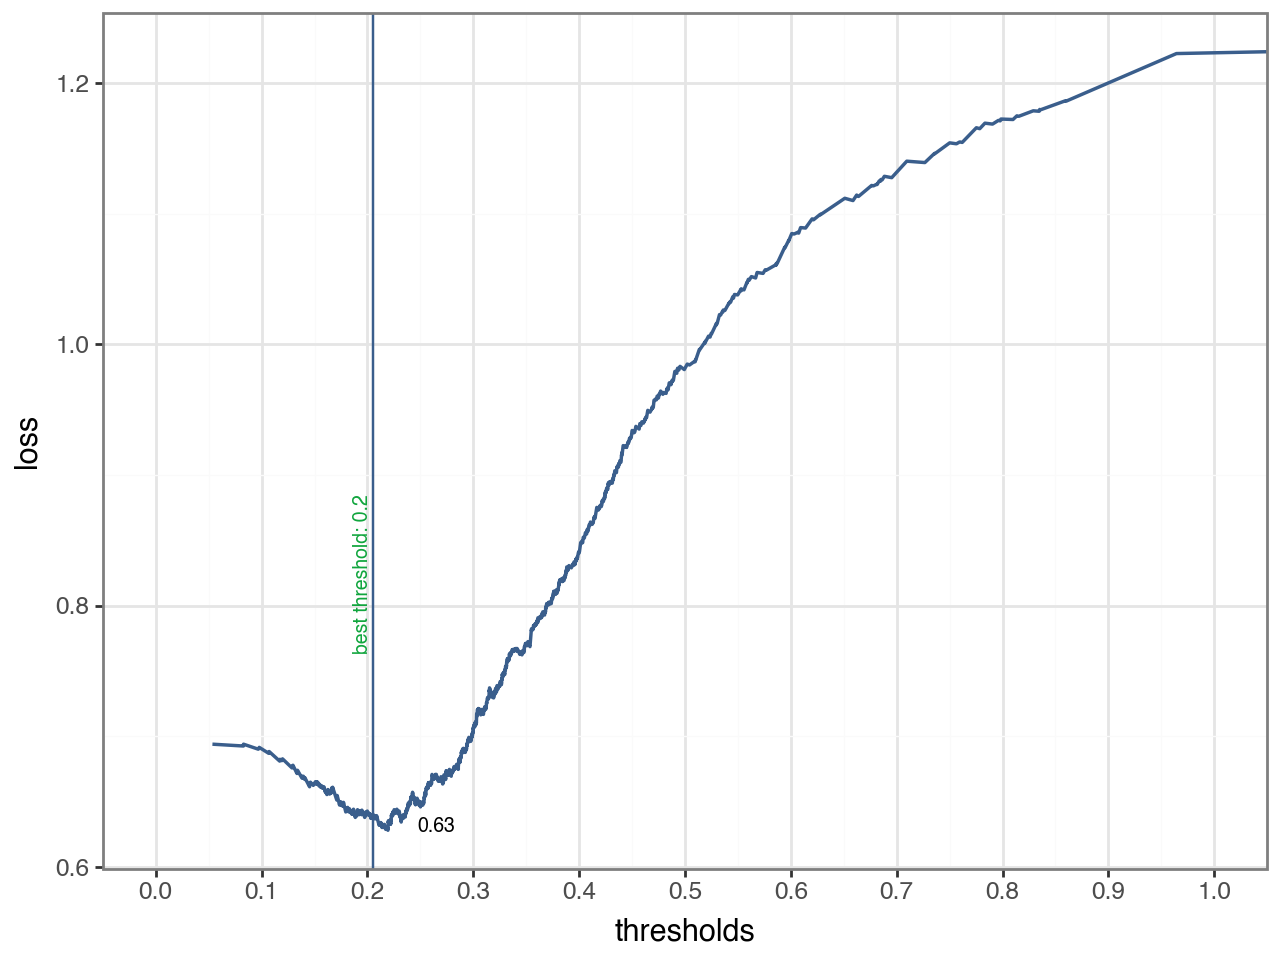

In [189]:
create_loss_plot(all_coords_xgb, fold5_threshold_xgb, fold5_expected_loss_xgb)

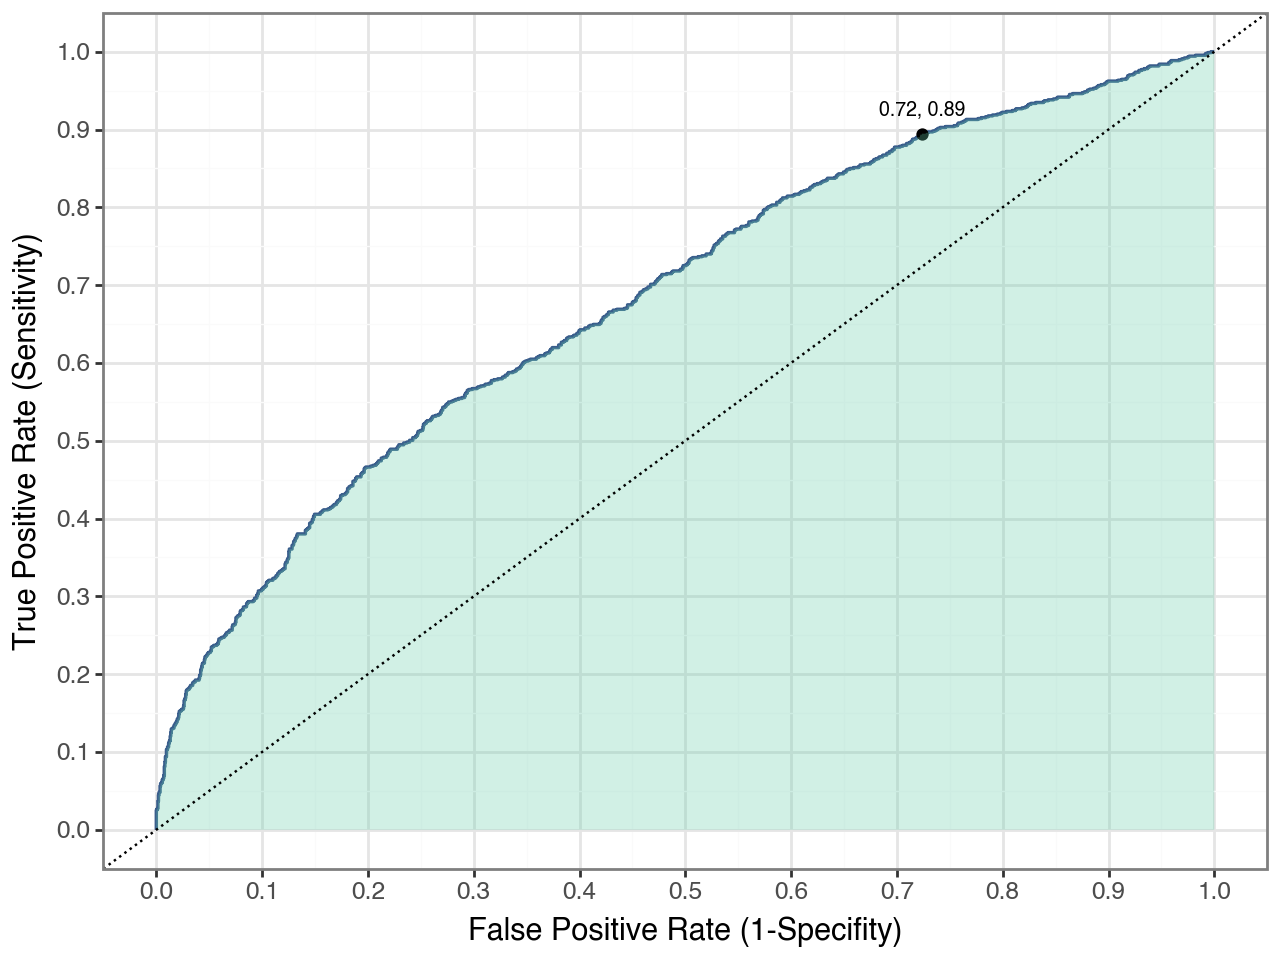

In [190]:
create_roc_plot_with_optimal(all_coords_xgb, fold5_threshold_xgb)

### Take model to holdout and estimate RMSE, AUC and expected loss 

In [191]:
xgb_fit_best = xgb_fit.best_estimator_
xgb_predicted_probabilities_holdout = xgb_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_xgb = np.sqrt(mean_squared_error(y_holdout, xgb_predicted_probabilities_holdout))
round(rmse_xgb, 3)

0.435

### ROC AUC  on holdout

In [192]:
auc_xgb = roc_auc_score(y_holdout, xgb_predicted_probabilities_holdout)
round(auc_xgb, 3)

0.685

###  Get expected loss on holdout

In [193]:
holdout_treshold = np.where(
    xgb_predicted_probabilities_holdout < best_thresholds_cv["XGB"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.645

### To compare the results of the RF modeling on `2012_hg_workfile_S.csv` with the previous results, we need to repeat the RF modeling steps for the new dataset `2012_hg_workfile_S.csv` and then compare the key metrics such as CV RMSE, CV AUC, thresholds, and expected loss.


In [215]:
# Store the average threshold and expected loss across folds
best_thresholds_cv_s = dict()
expected_loss_cv_s = dict()
expected_loss_cv_s["XGB"] = np.mean(expected_loss_s)
best_thresholds_cv_s["XGB"] = np.mean(best_thresholds_s)

    # Create a summary table comparing the metrics from both datasets
comparison_summary = pd.DataFrame(
        {
            "Metric": ["CV RMSE", "CV AUC", "Avg Threshold", "Avg Expected Loss"],
            "2012_hg_workfile_M": [
                round(prob_forest_best_results["cv_rmse"].values[0], 3),
                round(prob_forest_best_results["cv_auc"].values[0], 3),
                round(best_thresholds_cv["XGB"], 3),
                round(expected_loss_cv["XGB"], 3),
            ],
            "2012_hg_workfile_S": [
                round(xgb_best_results_s["cv_rmse"].values[0], 3),
                round(xgb_best_results_s["cv_auc"].values[0], 3),
                round(best_thresholds_cv_s["XGB"], 3),
                round(expected_loss_cv_s["XGB"], 3),
            ],
        }
    )

    # Display the comparison summary
comparison_summary

,Metric,2012_hg_workfile_M,2012_hg_workfile_S
0,CV RMSE,0.439,0.432
1,CV AUC,0.677,0.701
2,Avg Threshold,0.194,0.218
3,Avg Expected Loss,0.640,0.615


## Analysis of Results:

### Discriminatory Power: The services sector has a higher AUC, suggesting that the XGBoost model is better at distinguishing between high-growth and non-high-growth firms in services. This may indicate that growth patterns in services are more predictable or that the features are more informative for this sector.
### Thresholding: The higher threshold in the services sector could suggest a preference for caution in identifying high-growth firms in this industry, possibly due to the typically more unpredictable or seasonal nature of services businesses compared to manufacturing.
### Expected Loss: The model performs more efficiently in the services sector, as indicated by the lower average expected loss. This means that the XGBoost model is better at balancing false positives and false negatives in services firms, which is crucial for making cost-effective decisions.
## Model Performance Comparison:

### Overall, while both sectors show good performance, the services sector appears to benefit slightly more from the model, with a higher AUC and a lower expected loss. This suggests that the XGBoost model is more suited for predicting high-growth firms in the services industry, potentially due to the clearer patterns of growth in this sector.
### The manufacturing sector performs well but shows slightly higher expected loss, which may indicate more noise or unpredictability in the growth patterns of manufacturing firms due to smaller data size.